# [ LG에너지솔루션 DX Expert 양성과정 ]

Vision Transformer를 활용한 image classification
- 이론교육 자료 [ link ](http://dsba.korea.ac.kr/wp-content/uploads/2023/06/9_2%E1%84%8C%E1%85%AE-4%E1%84%8B%E1%85%B5%E1%86%AF-Transformer-%E1%84%80%E1%85%B5%E1%86%B7%E1%84%86%E1%85%B5%E1%84%89%E1%85%AE%E1%86%A8.pdf)

In [ ]:
!pip install timm==0.9.2
!pip install einops

# Import modules

In [ ]:
import os
import random
import numpy as np
import pandas as pd
from collections import defaultdict
from einops import rearrange

from time import time
from tqdm.auto import tqdm

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score

import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets

from timm import list_models, create_model

import cv2
import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Functions

In [ ]:
def torch_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    # CUDA randomness
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    np.random.seed(random_seed)
    random.seed(random_seed)
    os.environ['PYTHONHASHSEED'] = str(random_seed)

def calc_metrics(y_true: list, y_score: np.ndarray, y_pred: list) -> dict:
    # softmax
    y_score = nn.functional.softmax(torch.FloatTensor(y_score), dim=1)

    # metrics
    auroc = roc_auc_score(y_true, y_score, average='macro', multi_class='ovr')
    f1 = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')

    return {
        'auroc'    : auroc,
        'f1'       : f1,
        'recall'   : recall,
        'precision': precision
    }

def train(model, dataloader, criterion, optimizer, log_interval: int, device: str) -> list:

    correct = 0
    total = 0
    total_loss = 0
    total_score = []
    total_preds = []
    total_targets = []

    model.train()

    for i, (inputs, targets) in enumerate(dataloader):
        # convert device
        inputs, targets = inputs.to(device), targets.to(device)

        # model outputs
        outputs = model(inputs)

        # loss
        loss = criterion(outputs, targets)

        # calculate gradients
        loss.backward()

        # update model weights
        optimizer.step()
        optimizer.zero_grad()

        # total loss and acc
        total_loss += loss.item()
        preds = outputs.argmax(dim=1)

        correct += targets.eq(preds).sum().item()
        total += targets.size(0)

        total_score.extend(outputs.cpu().tolist())
        total_preds.extend(preds.cpu().tolist())
        total_targets.extend(targets.cpu().tolist())

        # log learning history
        if i % log_interval == 0 or (i+1) == len(dataloader):
            print('TRAIN [%5d/%5d]: Loss: %.3f | Acc: %.3f%% [%5d/%5d]' %
                 (i+1, len(dataloader), total_loss/(i+1), 100.*correct/total, correct, total))

    # calculate metrics
    metrics = calc_metrics(
        y_true  = total_targets,
        y_score = total_score,
        y_pred  = total_preds
    )

    metrics.update([('acc',correct/total), ('loss',total_loss/len(dataloader))])

    # logging metrics
    print('\nTRAIN: Loss: %.3f | Acc: %.3f%% | AUROC: %.3f%% | F1-Score: %.3f%% | Recall: %.3f%% | Precision: %.3f%%\n' %
         (metrics['loss'], 100.*metrics['acc'], 100.*metrics['auroc'], 100.*metrics['f1'], 100.*metrics['recall'], 100.*metrics['precision']))


    return metrics

def test(model, dataloader, criterion, log_interval: int, device: str) -> list:

    correct = 0
    total = 0
    total_loss = 0
    total_score = []
    total_preds = []
    total_targets = []

    torch_seed(223)
    model.eval()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            # convert device
            inputs, targets = inputs.to(device), targets.to(device)

            # model outputs
            outputs = model(inputs)

            # loss
            loss = criterion(outputs, targets)

            # total loss and acc
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)

            correct += targets.eq(preds).sum().item()
            total += targets.size(0)

            total_score.extend(outputs.cpu().tolist())
            total_preds.extend(preds.cpu().tolist())
            total_targets.extend(targets.cpu().tolist())

            # log learning history
            if i % log_interval == 0 or (i+1) == len(dataloader):
                print('TEST [%5d/%5d]: Loss: %.3f | Acc: %.3f%% [%5d/%5d]' %
                      (i+1, len(dataloader), total_loss/(i+1), 100.*correct/total, correct, total))

    # calculate metrics
    metrics = calc_metrics(
        y_true  = total_targets,
        y_score = total_score,
        y_pred  = total_preds
    )

    metrics.update([('acc',correct/total), ('loss',total_loss/len(dataloader))])

    # logging metrics
    print('\nTEST: Loss: %.3f | Acc: %.3f%% | AUROC: %.3f%% | F1-Score: %.3f%% | Recall: %.3f%% | Precision: %.3f%%\n' %
         (metrics['loss'], 100.*metrics['acc'], 100.*metrics['auroc'], 100.*metrics['f1'], 100.*metrics['recall'], 100.*metrics['precision']))

    # return
    return metrics


def fit(
    model, trainloader, testloader, criterion, optimizer, epochs: int, log_interval: int, device: str) -> list:

    train_history = defaultdict(list)
    test_history = defaultdict(list)

    # fitting model
    for i in range(epochs):
        print(f'\nEpoch: [{i+1}/{epochs}]')
        train_metrics = train(
            model        = model,
            dataloader   = trainloader,
            criterion    = criterion,
            optimizer    = optimizer,
            log_interval = log_interval,
            device       = device,
        )

        test_metrics = test(
            model        = model,
            dataloader   = testloader,
            criterion    = criterion,
            log_interval = log_interval,
            device       = device
        )

        # stack history
        for k, v in train_metrics.items():
            train_history[k].append(v)
        for k, v in test_metrics.items():
            test_history[k].append(v)

    return train_history, test_history

# Configuration for experiments

In [ ]:
class Config:
    # dataset 관련 parameters
    datadir = './data'
    image_size = [32, 32]
    num_classes = 10

    # training 관련 parameters
    epochs = 10
    batch_size = 32
    test_batch_size = 128
    learning_rate = 0.001
    num_workers = 2
    log_interval = 200

    # device
    device = 'cuda'

    # seed
    seed = 223

cfg = Config()

# Load dataset and dataloader

In [ ]:
trainset = datasets.CIFAR10(root=cfg.datadir, train=True, download=True, transform=transforms.ToTensor())
testset = datasets.CIFAR10(root=cfg.datadir, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
trainloader = DataLoader(trainset, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
testloader = DataLoader(testset, batch_size=cfg.test_batch_size, shuffle=False, num_workers=cfg.num_workers)

In [ ]:
print('the number of images in trainset: ',len(trainset.data))
print('the number of images in testset: ',len(testset.data))
print()
print('image size: ',trainset.data[0].shape)
print('target category')
print(trainset.class_to_idx)

the number of images in trainset:  50000
the number of images in testset:  10000

image size:  (32, 32, 3)
target category
{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


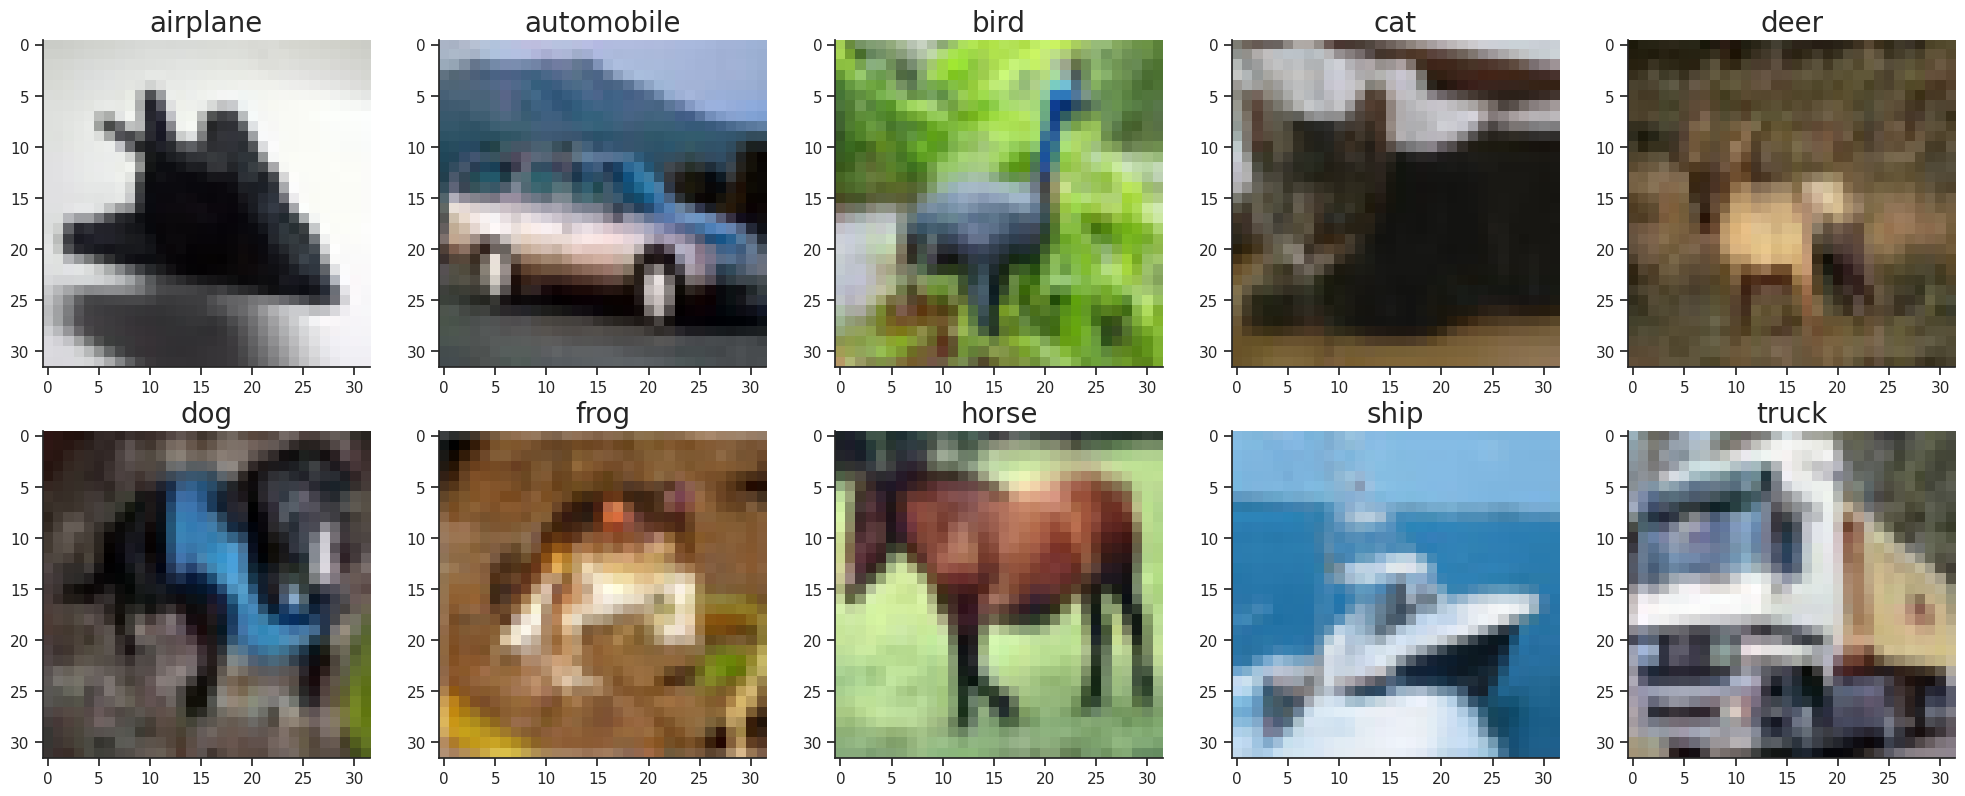

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(20,8))

for i in range(10):
    idx = torch.where(torch.Tensor(trainset.targets)==i)[0][0]
    ax[i//5, i%5].imshow(trainset[idx][0].permute(1,2,0))
    ax[i//5, i%5].set_title(list(trainset.class_to_idx.keys())[i], size=20)
plt.tight_layout()
plt.show()

# Vision Transformer

## without pretrained weights

In [ ]:
model_wo_pretrained = create_model(
    model_name  = 'vit_base_patch8_224',
    img_size    = cfg.image_size,
    num_classes = cfg.num_classes
)
model_wo_pretrained.to(cfg.device)
print('load model')
print('The number of model parameters: ',sum([p.numel() for p in model_wo_pretrained.parameters()]))

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model_wo_pretrained.parameters(), lr=cfg.learning_rate)

load model
The number of model parameters:  85225738


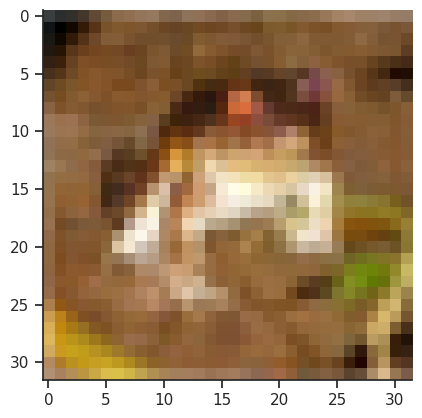

In [ ]:
img_temp = trainset[0][0]
plt.imshow(img_temp.permute(1,2,0))
plt.show()

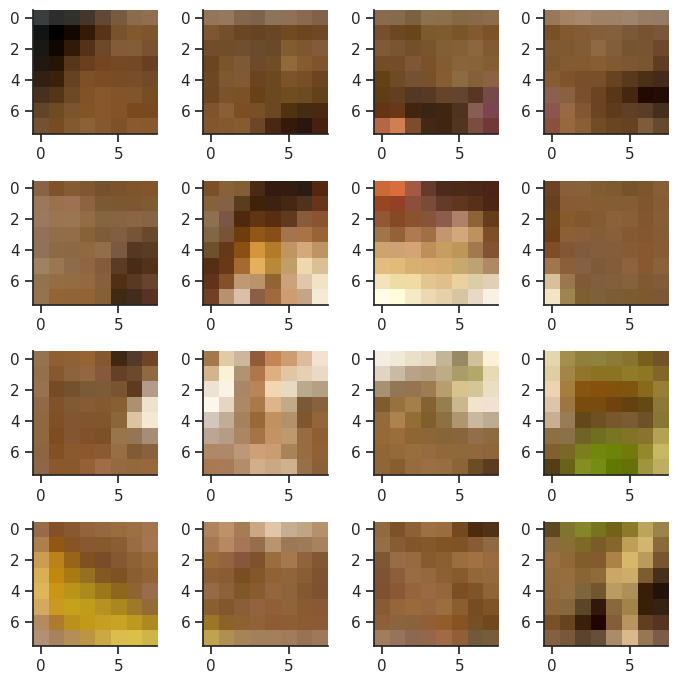

In [ ]:
# patchify
img_temp_patch = rearrange(img_temp, 'c (h ph) (w pw) -> (h w) (ph pw c)', ph=8, pw=8)

fig, ax = plt.subplots(4,4,figsize=(7,7))

for i in range(len(img_temp_patch)):
    ax[i//4, i%4].imshow(img_temp_patch[i].reshape(8, 8, 3))

plt.tight_layout()
plt.show()

In [ ]:
# patch embedding
temp_out = model_wo_pretrained.patch_embed(img_temp.unsqueeze(0).to(cfg.device))
print(temp_out.shape)

torch.Size([1, 16, 768])


In [ ]:
# encoder outputs
temp_out = model_wo_pretrained.forward_features(img_temp.unsqueeze(0).to(cfg.device))
print(temp_out.shape)

torch.Size([1, 17, 768])


In [ ]:
# head outputs
temp_out = model_wo_pretrained.head(temp_out[:,0,:])
print(temp_out.shape)

torch.Size([1, 10])


### Training model

In [ ]:
torch_seed(cfg.seed)
train_history_wo_pretrained, test_history_wo_pretrained = fit(
    model        = model_wo_pretrained,
    trainloader  = trainloader,
    testloader   = testloader,
    criterion    = criterion,
    optimizer    = optimizer,
    epochs       = cfg.epochs,
    log_interval = cfg.log_interval,
    device       = cfg.device
)


Epoch: [1/10]
TRAIN [    1/ 1563]: Loss: 2.384 | Acc: 12.500% [    4/   32]
TRAIN [  201/ 1563]: Loss: 2.193 | Acc: 17.522% [ 1127/ 6432]
TRAIN [  401/ 1563]: Loss: 2.139 | Acc: 19.615% [ 2517/12832]
TRAIN [  601/ 1563]: Loss: 2.108 | Acc: 21.147% [ 4067/19232]
TRAIN [  801/ 1563]: Loss: 2.089 | Acc: 21.758% [ 5577/25632]
TRAIN [ 1001/ 1563]: Loss: 2.071 | Acc: 22.537% [ 7219/32032]
TRAIN [ 1201/ 1563]: Loss: 2.054 | Acc: 23.303% [ 8956/38432]
TRAIN [ 1401/ 1563]: Loss: 2.040 | Acc: 23.889% [10710/44832]
TRAIN [ 1563/ 1563]: Loss: 2.031 | Acc: 24.334% [12167/50000]

TRAIN: Loss: 2.031 | Acc: 24.334% | AUROC: 71.854% | F1-Score: 23.598% | Recall: 24.334% | Precision: 23.447%

TEST [    1/   79]: Loss: 1.894 | Acc: 25.000% [   32/  128]
TEST [   79/   79]: Loss: 1.958 | Acc: 28.370% [ 2837/10000]

TEST: Loss: 1.958 | Acc: 28.370% | AUROC: 77.818% | F1-Score: 25.039% | Recall: 28.370% | Precision: 32.529%


Epoch: [2/10]
TRAIN [    1/ 1563]: Loss: 1.977 | Acc: 31.250% [   10/   32]
TRAIN

TRAIN [    1/ 1563]: Loss: 1.229 | Acc: 56.250% [   18/   32]
TRAIN [  201/ 1563]: Loss: 1.202 | Acc: 56.996% [ 3666/ 6432]
TRAIN [  401/ 1563]: Loss: 1.198 | Acc: 57.263% [ 7348/12832]
TRAIN [  601/ 1563]: Loss: 1.196 | Acc: 57.342% [11028/19232]
TRAIN [  801/ 1563]: Loss: 1.187 | Acc: 57.600% [14764/25632]
TRAIN [ 1001/ 1563]: Loss: 1.183 | Acc: 57.848% [18530/32032]
TRAIN [ 1201/ 1563]: Loss: 1.179 | Acc: 57.954% [22273/38432]
TRAIN [ 1401/ 1563]: Loss: 1.170 | Acc: 58.331% [26151/44832]
TRAIN [ 1563/ 1563]: Loss: 1.169 | Acc: 58.394% [29197/50000]

TRAIN: Loss: 1.169 | Acc: 58.394% | AUROC: 91.956% | F1-Score: 58.113% | Recall: 58.394% | Precision: 57.980%

TEST [    1/   79]: Loss: 1.237 | Acc: 57.031% [   73/  128]
TEST [   79/   79]: Loss: 1.408 | Acc: 50.290% [ 5029/10000]

TEST: Loss: 1.408 | Acc: 50.290% | AUROC: 89.418% | F1-Score: 49.411% | Recall: 50.290% | Precision: 53.032%



In [ ]:
def figure(all_train_history: list, all_test_history: list, all_exp_name: list) -> None:
    fig, ax = plt.subplots(2, 6, figsize=(20,7))

    # train line plot
    for train_h, exp_name in zip(all_train_history, all_exp_name):
        for i, (k, v) in enumerate(train_h.items()):
            sns.lineplot(
                x     = range(1, len(v)+1),
                y     = v,
                label = exp_name,
                ax    = ax[0, i]
            )
            # set y axis label
            ax[0, i].set_ylabel(f'{k.upper()}')
            # set x axis label
            ax[0, i].set_xlabel('Epochs')
            # set title
            ax[0, i].set_title(f'{k.upper()} of Trainset')
            # set legend
            ax[0, i].legend(loc='lower right')
            # set ylim
            if k != 'loss':
                ax[0, i].set_ylim(0, 1)

    # test lineplot
    for test_h, exp_name in zip(all_test_history, all_exp_name):
        for i, (k, v) in enumerate(test_h.items()):
            sns.lineplot(
                x     = range(1, len(v)+1),
                y     = v,
                label = exp_name,
                ax    = ax[1, i]
            )
            # set y axis label
            ax[1, i].set_ylabel(f'{k.upper()}')
            # set x axis label
            ax[1, i].set_xlabel('Epochs')
            # set title
            ax[1, i].set_title(f'{k.upper()} of Testset')
            # set legend
            ax[1, i].legend(loc='lower right')
            # set ylim
            if k != 'loss':
                ax[0, i].set_ylim(0, 1)


    plt.tight_layout()
    plt.show()

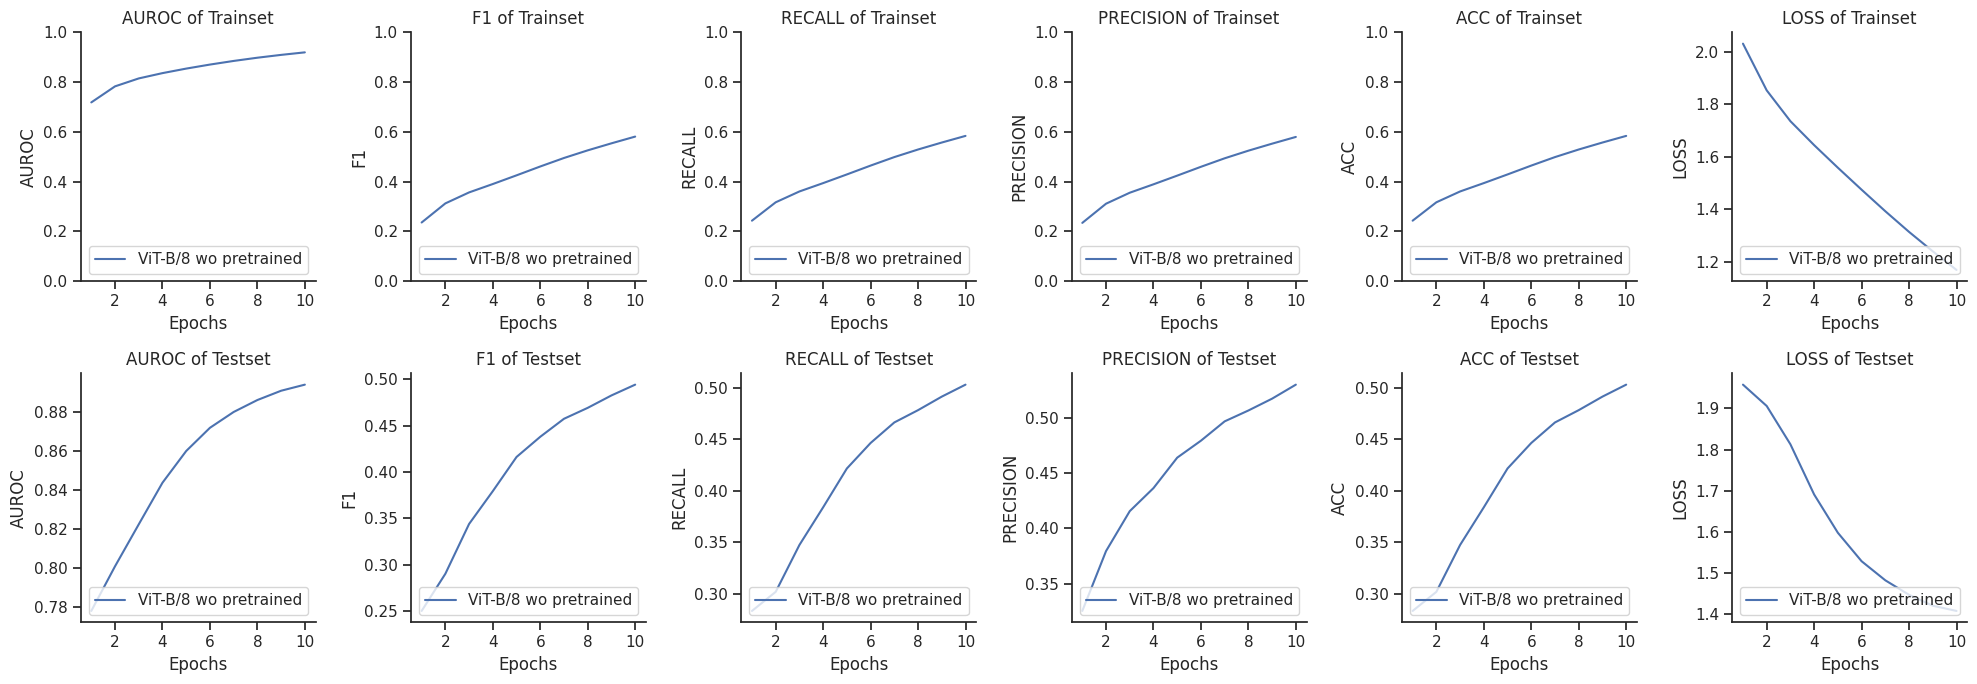

In [ ]:
all_train_history = [train_history_wo_pretrained]
all_test_history = [test_history_wo_pretrained]
all_exp_name = ['ViT-B/8 wo pretrained']

figure(
    all_train_history = all_train_history,
    all_test_history  = all_test_history,
    all_exp_name      = all_exp_name
)

## with pretrained weights

In [ ]:
model_w_pretrained = create_model(
    model_name  = 'vit_base_patch8_224.augreg_in21k',
    img_size    = cfg.image_size,
    num_classes = cfg.num_classes,
    pretrained  = True
)
model_w_pretrained.to(cfg.device)
print('load model')
print('The number of model parameters: ',sum([p.numel() for p in model_w_pretrained.parameters()]))

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model_w_pretrained.parameters(), lr=cfg.learning_rate)

load model
The number of model parameters:  85225738


### Training model

In [ ]:
torch_seed(cfg.seed)
train_history_w_pretrained, test_history_w_pretrained = fit(
    model        = model_w_pretrained,
    trainloader  = trainloader,
    testloader   = testloader,
    criterion    = criterion,
    optimizer    = optimizer,
    epochs       = cfg.epochs,
    log_interval = cfg.log_interval,
    device       = cfg.device
)


Epoch: [1/10]
TRAIN [    1/ 1563]: Loss: 3.395 | Acc: 6.250% [    2/   32]
TRAIN [  201/ 1563]: Loss: 2.145 | Acc: 20.989% [ 1350/ 6432]
TRAIN [  401/ 1563]: Loss: 1.987 | Acc: 27.050% [ 3471/12832]
TRAIN [  601/ 1563]: Loss: 1.854 | Acc: 32.170% [ 6187/19232]
TRAIN [  801/ 1563]: Loss: 1.734 | Acc: 36.661% [ 9397/25632]
TRAIN [ 1001/ 1563]: Loss: 1.626 | Acc: 40.697% [13036/32032]
TRAIN [ 1201/ 1563]: Loss: 1.523 | Acc: 44.463% [17088/38432]
TRAIN [ 1401/ 1563]: Loss: 1.435 | Acc: 47.740% [21403/44832]
TRAIN [ 1563/ 1563]: Loss: 1.372 | Acc: 50.098% [25049/50000]

TRAIN: Loss: 1.372 | Acc: 50.098% | AUROC: 88.653% | F1-Score: 49.821% | Recall: 50.098% | Precision: 49.676%

TEST [    1/   79]: Loss: 0.863 | Acc: 66.406% [   85/  128]
TEST [   79/   79]: Loss: 0.936 | Acc: 66.640% [ 6664/10000]

TEST: Loss: 0.936 | Acc: 66.640% | AUROC: 95.755% | F1-Score: 67.467% | Recall: 66.640% | Precision: 73.365%


Epoch: [2/10]
TRAIN [    1/ 1563]: Loss: 0.542 | Acc: 81.250% [   26/   32]
TRAIN 

TRAIN [    1/ 1563]: Loss: 0.052 | Acc: 96.875% [   31/   32]
TRAIN [  201/ 1563]: Loss: 0.032 | Acc: 98.647% [ 6345/ 6432]
TRAIN [  401/ 1563]: Loss: 0.035 | Acc: 98.644% [12658/12832]
TRAIN [  601/ 1563]: Loss: 0.039 | Acc: 98.534% [18950/19232]
TRAIN [  801/ 1563]: Loss: 0.037 | Acc: 98.654% [25287/25632]
TRAIN [ 1001/ 1563]: Loss: 0.035 | Acc: 98.698% [31615/32032]
TRAIN [ 1201/ 1563]: Loss: 0.035 | Acc: 98.728% [37943/38432]
TRAIN [ 1401/ 1563]: Loss: 0.035 | Acc: 98.715% [44256/44832]
TRAIN [ 1563/ 1563]: Loss: 0.036 | Acc: 98.686% [49343/50000]

TRAIN: Loss: 0.036 | Acc: 98.686% | AUROC: 99.988% | F1-Score: 98.686% | Recall: 98.686% | Precision: 98.686%

TEST [    1/   79]: Loss: 0.309 | Acc: 91.406% [  117/  128]
TEST [   79/   79]: Loss: 0.488 | Acc: 88.920% [ 8892/10000]

TEST: Loss: 0.488 | Acc: 88.920% | AUROC: 99.248% | F1-Score: 88.952% | Recall: 88.920% | Precision: 89.110%



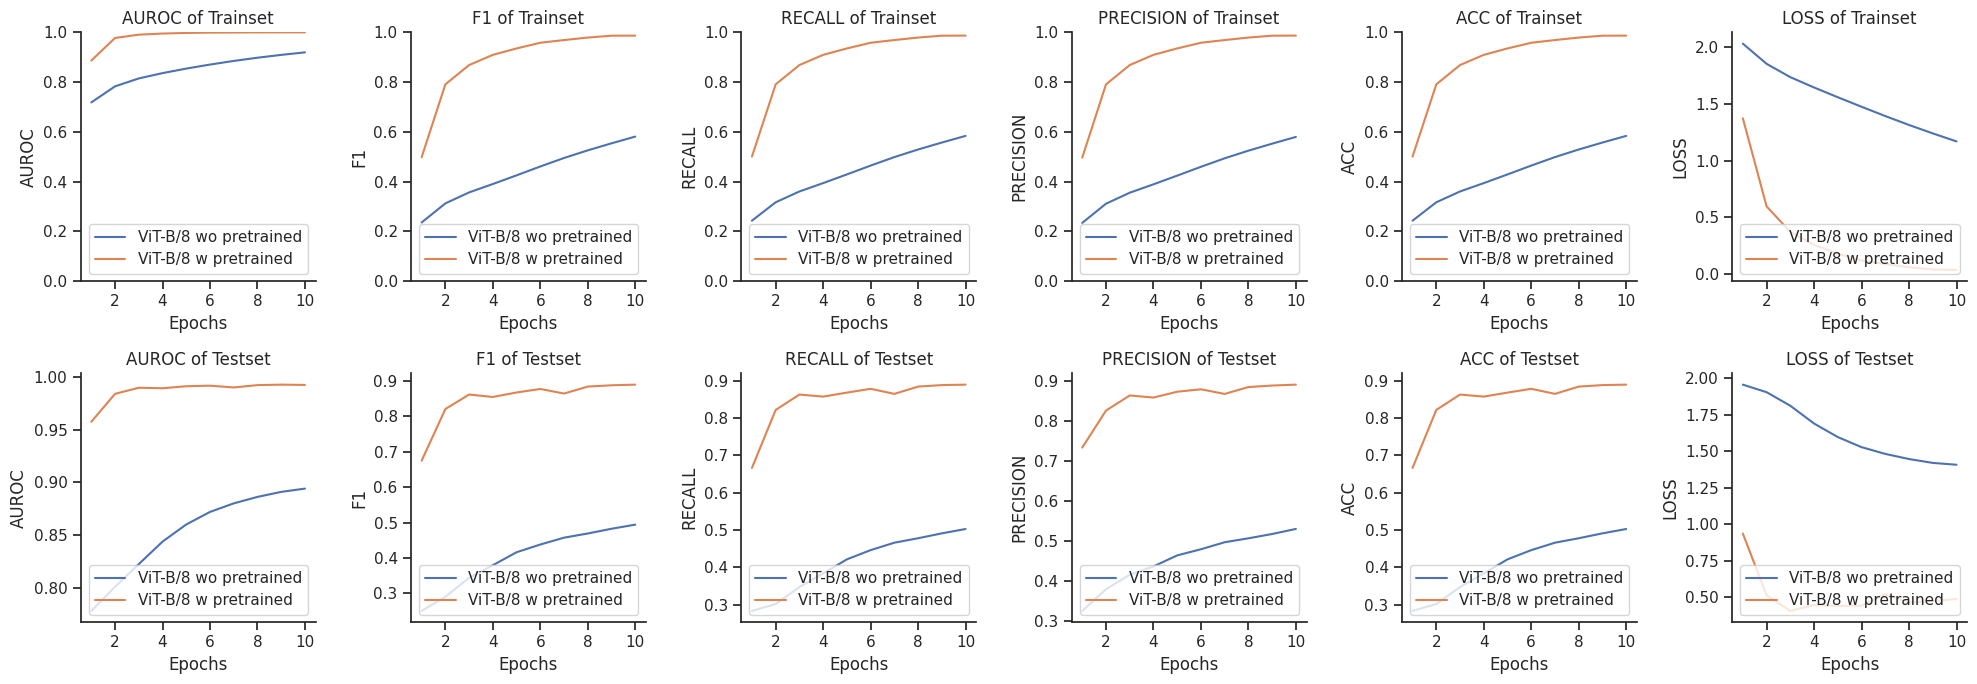

In [ ]:
all_train_history.append(train_history_w_pretrained)
all_test_history.append(test_history_w_pretrained)
all_exp_name.append('ViT-B/8 w pretrained')

figure(
    all_train_history = all_train_history,
    all_test_history  = all_test_history,
    all_exp_name      = all_exp_name
)

# Visualization

## Position embedding

In [ ]:
def pos_cos_figure(model):
    num_patch = int(len(model.pos_embed[0]) - 1)
    row = int(np.sqrt(num_patch))
    col = int(np.sqrt(num_patch))

    fig, ax = plt.subplots(row, col, figsize=(7,7))

    for p_i in range(num_patch):
        sim_matrix_i = np.zeros((row, col))
        for p_j in range(num_patch):
            sim_matrix_i[p_j//col, p_j%col] = nn.functional.cosine_similarity(
                x1  = model.pos_embed[0,p_i+1,:],
                x2  = model.pos_embed[0,p_j+1,:],
                dim = 0
            ).item()

        # heatmap
        sns.heatmap(sim_matrix_i, cmap='viridis', vmax=1, ax=ax[p_i//col, p_i%col])
        ax[p_i//col, p_i%col].axis('off')

    plt.tight_layout()
    plt.show()

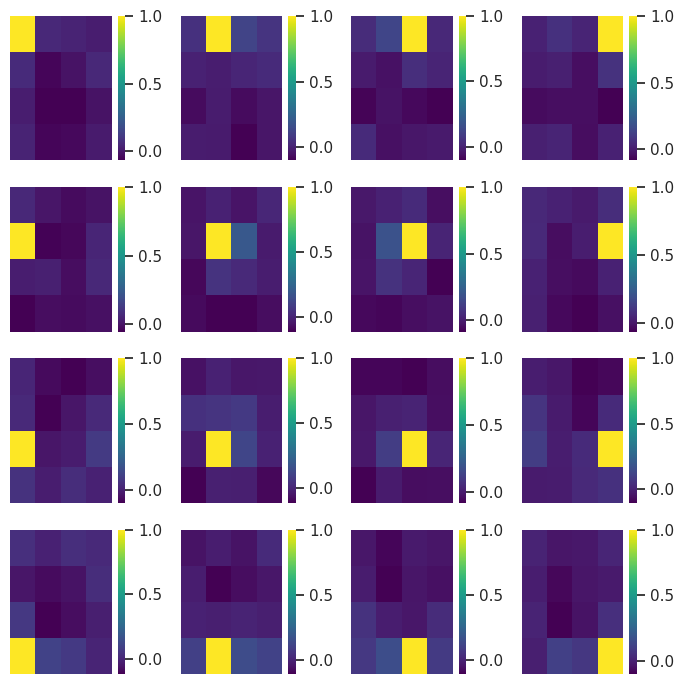

In [ ]:
pos_cos_figure(model_wo_pretrained)

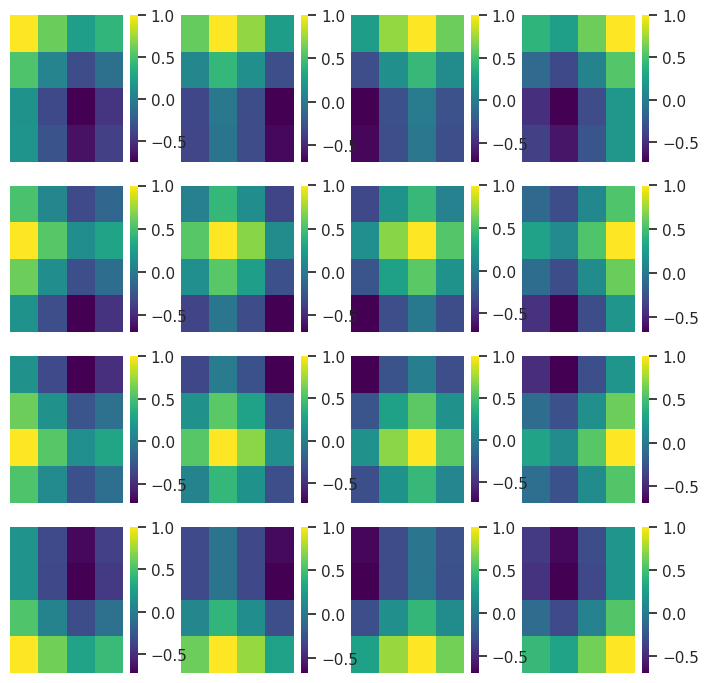

In [ ]:
pos_cos_figure(model_w_pretrained)

## Visualize attention map

In [ ]:
activation = {}

# get attention score
def get_attn_softmax(name):
    def hook(model, input, output):
        with torch.no_grad():
            input = input[0]

            B, N, C = input.shape
            qkv = model.qkv(input).detach().reshape(B, N, 3, model.num_heads, C // model.num_heads)
            qkv = qkv.permute(2, 0, 3, 1, 4)

            q, k, v = (qkv[0], qkv[1], qkv[2],)
            attn = (q @ k.transpose(-2, -1)) * model.scale
            attn = attn.softmax(dim=-1)

            activation[name] = attn

    return hook


# fowrad hook for attention score
def add_attn_vis_hook(model):
    for idx, module in enumerate(list(model.blocks.children())):
        module.attn.register_forward_hook(get_attn_softmax(f"attn{idx}"))


# get blended image with attention score
def blend_attention_with_image(image: np.ndarray, activation: dict):
    # aggregation attention
    attn_agg = torch.cat(list(activation.values())).sum(dim=(0,1))[0, 1:].softmax(dim=0).cpu().numpy()
    attn_agg = attn_agg.reshape(4,4)
    attn_agg = cv2.resize(attn_agg, dsize=(32,32))
    # scaling
    attn_agg = (attn_agg - attn_agg.min()) / (attn_agg.max() - attn_agg.min())

    # blending
    attn_agg = np.expand_dims(attn_agg, axis=-1)
    img_blend = image * 0.5 + attn_agg * 0.8
    # scaling
    img_blend = (img_blend - img_blend.min()) / (img_blend.max() - img_blend.min())

    return img_blend

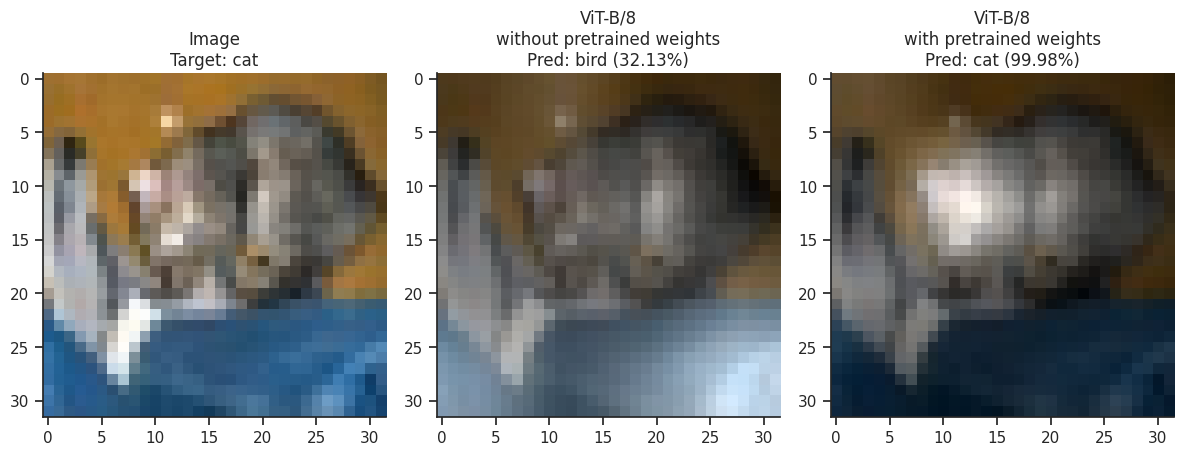

In [ ]:
img, target = testset[0]
img_show = img.permute(1,2,0).numpy()

# target
class_name = list(testset.class_to_idx.keys())
target_name = class_name[target]

# with pretrained weights
add_attn_vis_hook(model_wo_pretrained)
output = model_wo_pretrained(img.unsqueeze(0).to(cfg.device))
pred_wo_pretrained = output.argmax(dim=1)[0].item()
prob_wo_pretrained = nn.functional.softmax(output, dim=1)[0][pred_wo_pretrained]

img_blend_wo_pretrained = blend_attention_with_image(image=img_show, activation=activation)

# with pretrained weights
add_attn_vis_hook(model_w_pretrained)
output = model_w_pretrained(img.unsqueeze(0).to(cfg.device))
pred_w_pretrained = output.argmax(dim=1)[0].item()
prob_w_pretrained = nn.functional.softmax(output, dim=1)[0][pred_w_pretrained]

img_blend_w_pretrained = blend_attention_with_image(image=img_show, activation=activation)

# figure
fig, ax = plt.subplots(1,3,figsize=(12,5))

ax[0].imshow(img_show)
ax[1].imshow(img_blend_wo_pretrained)
ax[2].imshow(img_blend_w_pretrained)

# set title
ax[0].set_title(f'Image\nTarget: {target_name}')
ax[1].set_title(f'ViT-B/8\nwithout pretrained weights\nPred: {class_name[pred_wo_pretrained]} ({prob_wo_pretrained:.2%})')
ax[2].set_title(f'ViT-B/8\nwith pretrained weights\nPred: {class_name[pred_w_pretrained]} ({prob_w_pretrained:.2%})')
plt.tight_layout()
plt.show()